# Relative Performance — Monash Index (Submission Notebook)

Este notebook reproduce el pipeline de la tarea:
- Clasificación binaria (outperform vs US Monash Index) para 2023-07 (métrica: F1).
- Regresión de exceso de retorno para 2023-07 (métrica: RMSE).
- Validación temporal sin leakage.
- Visualización de métricas y gráficos.
- Genera únicamente el archivo `testing_targets.csv` con 4 columnas requeridas.

Reproducible con semilla fija (42) y ejecutable en Google Colab.

In [1]:
%pip -q install scikit-learn pandas seaborn matplotlib scipy

Note: you may need to restart the kernel to use updated packages.


In [2]:
import os, random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
from IPython.display import display

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.metrics import f1_score, confusion_matrix

SEED = 42
random.seed(SEED); np.random.seed(SEED); os.environ['PYTHONHASHSEED'] = str(SEED)
TRAIN_END = '2023-06'
PREDICT_MONTH = '2023-07'
MACRO_LAG = 1
BASE = Path('.')
sns.set(style='whitegrid')

In [3]:
def parse_month_id(s: pd.Series) -> pd.Series:
    s = s.astype(str).str.replace('_','-', regex=False)
    return s.apply(lambda x: pd.Period(x, freq='M'))

def split_feature_columns(df: pd.DataFrame):
    exclude = {'stock_id','feature_month','target_month','y_cls','y_reg','month_id'}
    num_cols = df.select_dtypes(include=[np.number]).columns.difference(exclude).tolist()
    cat_cols = [c for c in df.columns if c not in num_cols and c not in exclude]
    return num_cols, cat_cols

def ohe_compatible():
    try:
        return OneHotEncoder(handle_unknown='ignore', sparse_output=False)
    except TypeError:
        return OneHotEncoder(handle_unknown='ignore', sparse=False)

def rmse(y_true, y_pred):
    y_true = np.asarray(y_true, float)
    y_pred = np.asarray(y_pred, float)
    return float(np.sqrt(np.mean((y_true - y_pred)**2)))

In [4]:
# Carga de datos
stock = pd.read_csv(BASE/'stock_data.csv')
index_df = pd.read_csv(BASE/'monashIndex.csv')
company = pd.read_csv(BASE/'company_info.csv')
vix = pd.read_csv(BASE/'vix_index.csv')
us10y = pd.read_csv(BASE/'us_10_year_treasury.csv')
us5y = pd.read_csv(BASE/'us_5_year_treasury.csv')
infl = pd.read_csv(BASE/'fed_inflation_rate.csv')
fedrate = pd.read_csv(BASE/'fed_funds_rate.csv')
unemp = pd.read_csv(BASE/'fed_unemployment_rate.csv')
train_tgt = pd.read_csv(BASE/'training_targets.csv').astype({'stock_id':'str'})
test_tgt = pd.read_csv(BASE/'testing_targets.csv').astype({'stock_id':'str'})

stock['stock_id'] = stock['stock_id'].astype(str)
company['stock_id'] = company['stock_id'].astype(str)
stock['month'] = parse_month_id(stock['month_id'])
index_df['month'] = parse_month_id(index_df['month_id'])
for df, col in [(vix,'vix'), (us10y,'10y_treasury'), (us5y,'5y_treasury'), (infl,'inflation_rate'), (fedrate,'fed_rate'), (unemp,'unemployment_rate')]:
    df['month'] = parse_month_id(df['month_id'])

print('Stock months:', stock['month'].min(), '->', stock['month'].max(), 'rows=', len(stock))
print('Train months:', train_tgt['month_id'].min(), '->', train_tgt['month_id'].max(), 'rows=', len(train_tgt))
display(stock.head(3))


Stock months: 2020-01 -> 2023-06 rows= 25618
Train months: 2020_01 -> 2023_06 rows= 25618


,stock_id,month_id,month_start_open_usd,month_end_close_usd,month_high_usd,month_low_usd,monthly_volume,intramonth_return,return_1m,return_3m,return_6m,intramonth_volatility,volatility_3m,volatility_6m,trading_days,avg_volume_3m,volume_ratio,price_range_ratio,month
0,US001,2020_01,120.192,107.326,123.486,107.035,84539259,-0.107045,-0.100669,-0.030041,-0.075676,0.253304,0.278396,0.201608,21,3182487.0,1.207,0.136875,2020-01
1,US001,2020_02,108.252,101.868,111.641,99.636,91313882,-0.058974,-0.050854,-0.112968,-0.060752,0.259208,0.245523,0.192782,19,3686371.0,1.126,0.110905,2020-02
2,US001,2020_03,103.301,93.178,105.622,77.841,177930833,-0.097995,-0.085299,-0.219214,-0.154874,0.892709,0.088364,0.213051,22,5360363.0,1.509,0.268931,2020-03


Preparacion de datos

## DATA UNDERSTANDING

Este bloque explora las variables de entrenamiento y características antes del modelado, para justificar la selección de señales, transformaciones y precauciones.
- Métodos univariados: tipos, faltantes, distribución (hist/KDE), asimetría y transformaciones (log1p).
- Métodos bivariados: correlaciones de Spearman con y_cls/y_reg, patrones por sector y tamaño, y mapas 2D de interacción.
- Temporalidad: tasa de positivos vs retorno del índice y VIX para entender regímenes.
- Outliers: IQR y winsorización segura (sin fuga temporal).
Estas evidencias motivan: (i) usar escalado + OHE, (ii) incluir macros con lag, (iii) tratar colas pesadas en volúmenes/ratios, (iv) preferir modelos no lineales (RF/HGB).


### Overview y Transformaciones

Summary of numerical and categorical columns

In [5]:
# Usar dataset original "stock" para el overview univariado
dfu = stock.copy()
num_cols_all = dfu.select_dtypes(include=['number']).columns.tolist()
cat_cols_all = [c for c in dfu.columns if c not in num_cols_all and c not in ['month']]
summary = []
for c in dfu.columns:
    miss = dfu[c].isna().mean()
    dtype = str(dfu[c].dtype)
    if c in num_cols_all:
        s = pd.to_numeric(dfu[c], errors='coerce')
        summary.append([c, dtype, miss, s.mean(), s.std(), s.min(), s.max()])
    else:
        summary.append([c, dtype, miss, None, None, None, None])
dict_df = pd.DataFrame(summary, columns=['feature','dtype','missing_rate','mean','std','min','max']).sort_values('missing_rate', ascending=False)
display(dict_df.head(20))


,feature,dtype,missing_rate,mean,std,min,max
10,return_6m,float64,0.005270,9.373876e-02,3.970243e-01,-0.878101,1.994221e+01
13,volatility_6m,float64,0.005270,3.563752e-01,2.407778e-01,0.020767,4.904750e+00
9,return_3m,float64,0.002459,4.224258e-02,2.245368e-01,-0.891459,6.892996e+00
12,volatility_3m,float64,0.002459,3.371325e-01,2.804322e-01,0.001361,7.123194e+00
16,volume_ratio,float64,0.001639,1.005413e+00,2.094507e-01,0.046000,2.602000e+00
15,avg_volume_3m,float64,0.001639,5.641095e+06,2.094349e+07,144.000000,6.000172e+08
8,return_1m,float64,0.000820,1.474041e-02,1.255801e-01,-0.832263,3.197183e+00
11,intramonth_volatility,float64,0.000078,3.844895e-01,2.530385e-01,0.037019,3.458247e+00
17,price_range_ratio,float64,0.000000,1.755904e-01,1.266333e-01,0.010922,3.457143e+00
14,trading_days,int64,0.000000,2.094441e+01,1.194822e+00,0.000000,2.300000e+01


Distributions and transformation suggestions

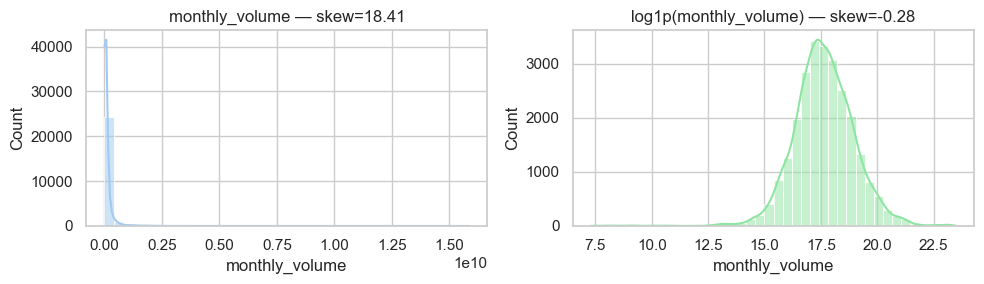

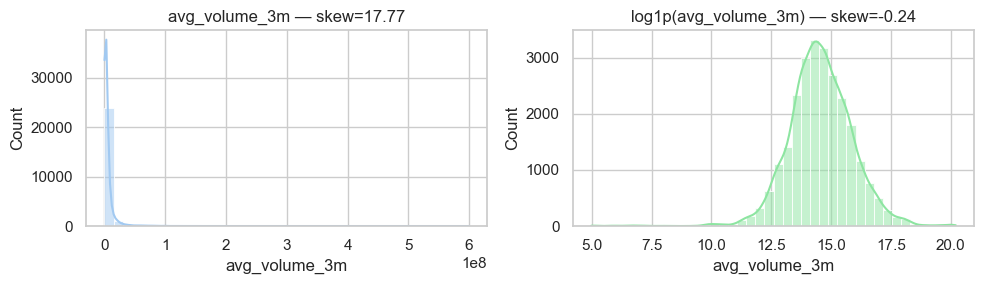

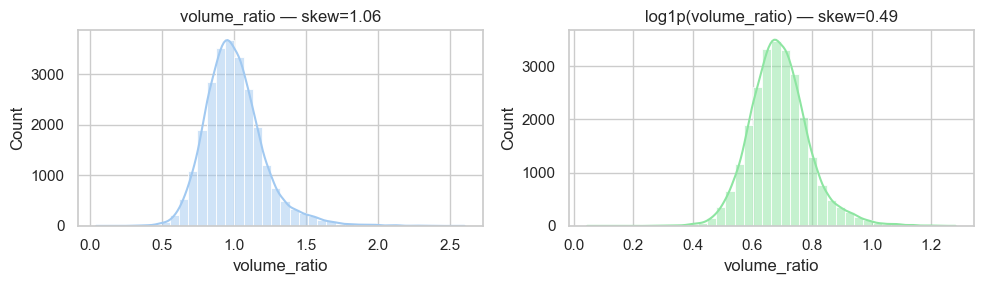

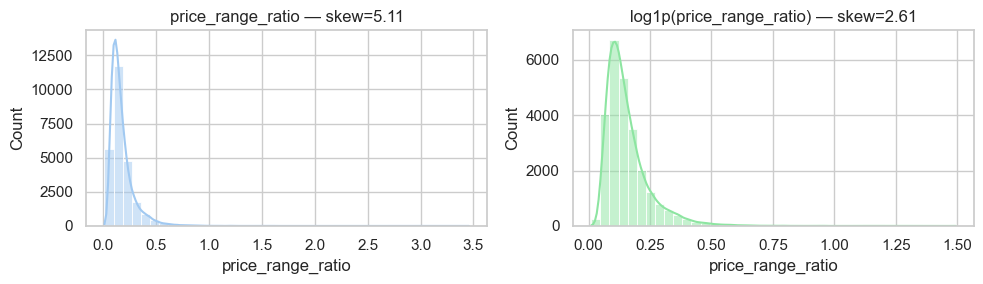

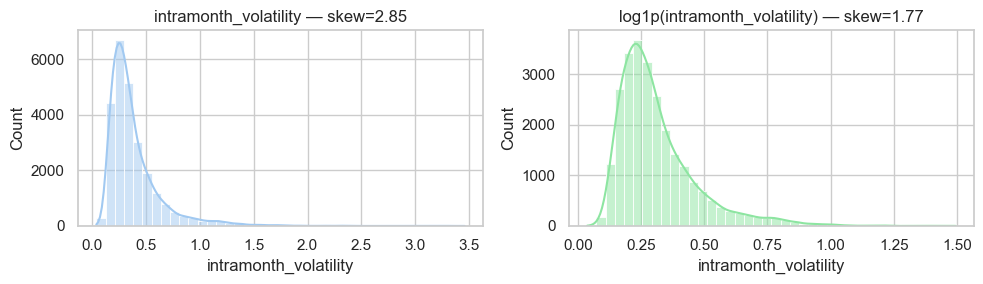

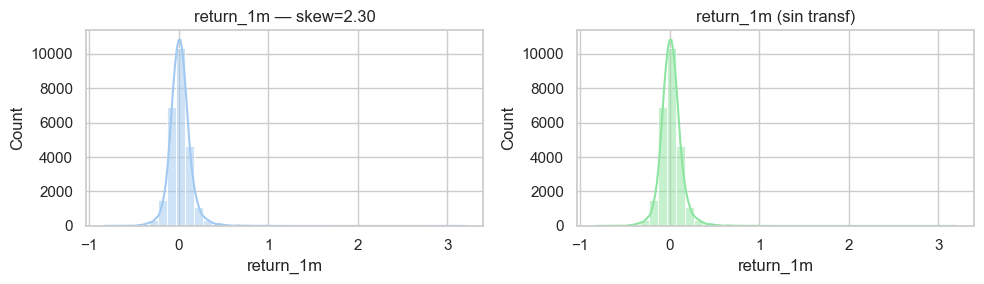

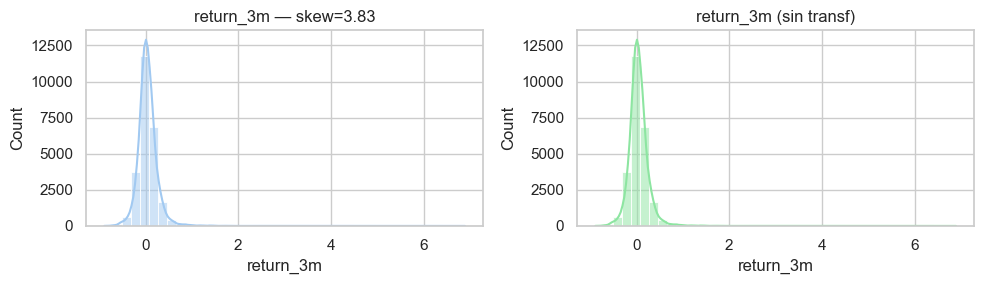

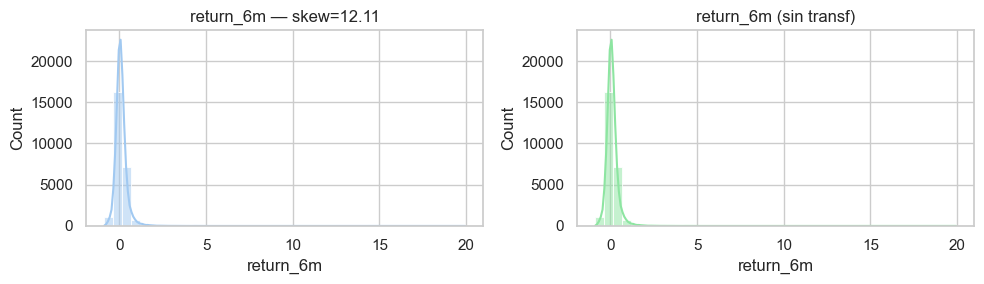

In [6]:
from scipy.stats import skew
cand = [c for c in ['monthly_volume','avg_volume_3m','volume_ratio','price_range_ratio','intramonth_volatility','return_1m','return_3m','return_6m'] if c in stock.columns]
for c in cand:
    s = pd.to_numeric(stock[c], errors='coerce').dropna()
    if s.empty:
        continue
    sk = float(skew(s))
    plt.figure(figsize=(10,3))
    plt.subplot(1,2,1); sns.histplot(s, bins=40, kde=True, color='#A1C9F1'); plt.title(f'{c} — skew={sk:.2f}')
    if (s>=0).all():
        s_tr = np.log1p(s)
        sk2 = float(skew(s_tr))
        plt.subplot(1,2,2); sns.histplot(s_tr, bins=40, kde=True, color='#8DE5A1'); plt.title(f'log1p({c}) — skew={sk2:.2f}')
    else:
        plt.subplot(1,2,2); sns.histplot(s, bins=40, kde=True, color='#8DE5A1'); plt.title(f'{c} (sin transf)')
    plt.tight_layout(); plt.show()


### Partnerships with Goals

We select y_cls and y_reg as objective columns:
* y_cls: Indicates whether the stock outperformed the index (1) or not (0). Metric: F1.
* y_reg: Continuous excess return: stock return − index return. Metric: RMSE.



In [7]:
from scipy.stats import spearmanr
# Construir 'eda_train' alineando stock (t-1) con targets (t) sin depender de 'train' del pipeline
tmp = stock.copy()
tmp['target_month'] = tmp['month'] + 1
tt = train_tgt.copy()
tt['month'] = parse_month_id(tt['month_id'])
eda_train = tmp.merge(tt[['stock_id','month','outperform_binary','excess_return']],
                      left_on=['stock_id','target_month'], right_on=['stock_id','month'], how='inner', suffixes=('', '_y'))
eda_train = eda_train.rename(columns={'outperform_binary':'y_cls','excess_return':'y_reg'})
exclude = {'stock_id','month','target_month','y_cls','y_reg'}
num_feats = [c for c in eda_train.columns if (c not in exclude) and pd.api.types.is_numeric_dtype(eda_train[c])]
rows = []
for c in num_feats:
    s = pd.to_numeric(eda_train[c], errors='coerce')
    sr_cls = spearmanr(s, eda_train['y_cls'], nan_policy='omit')
    sr_reg = spearmanr(s, eda_train['y_reg'], nan_policy='omit')
    rows.append([c, sr_cls.correlation, sr_cls.pvalue, sr_reg.correlation, sr_reg.pvalue])
corr_df = pd.DataFrame(rows, columns=['feature','rho_cls','p_cls','rho_reg','p_reg'])
display(corr_df.sort_values('rho_cls', key=lambda x: x.abs(), ascending=False).head(15))
display(corr_df.sort_values('rho_reg', key=lambda x: x.abs(), ascending=False).head(15))


,feature,rho_cls,p_cls,rho_reg,p_reg
14,volume_ratio,0.035796,1.541154e-08,0.031523,6.320480e-07
9,intramonth_volatility,0.028608,6.066538e-06,0.027673,1.208530e-05
3,month_low_usd,-0.024982,7.797875e-05,-0.031197,8.061403e-07
12,trading_days,0.024187,1.308885e-04,0.023262,2.345591e-04
1,month_end_close_usd,-0.024038,1.439459e-04,-0.030279,1.680015e-06
0,month_start_open_usd,-0.022658,3.397467e-04,-0.028307,7.583249e-06
2,month_high_usd,-0.022319,4.166635e-04,-0.028364,7.271524e-06
15,price_range_ratio,0.021391,7.180395e-04,0.024046,1.432279e-04
11,volatility_6m,0.018775,3.068986e-03,0.017626,5.443160e-03
10,volatility_3m,0.015995,1.153792e-02,0.017290,6.323466e-03


,feature,rho_cls,p_cls,rho_reg,p_reg
14,volume_ratio,0.035796,1.541154e-08,0.031523,6.320480e-07
3,month_low_usd,-0.024982,7.797875e-05,-0.031197,8.061403e-07
1,month_end_close_usd,-0.024038,1.439459e-04,-0.030279,1.680015e-06
2,month_high_usd,-0.022319,4.166635e-04,-0.028364,7.271524e-06
0,month_start_open_usd,-0.022658,3.397467e-04,-0.028307,7.583249e-06
9,intramonth_volatility,0.028608,6.066538e-06,0.027673,1.208530e-05
15,price_range_ratio,0.021391,7.180395e-04,0.024046,1.432279e-04
12,trading_days,0.024187,1.308885e-04,0.023262,2.345591e-04
11,volatility_6m,0.018775,3.068986e-03,0.017626,5.443160e-03
10,volatility_3m,0.015995,1.153792e-02,0.017290,6.323466e-03


### Patrones por Sector y Tamaño

Using sector column: sector | market cap column: market_cap_category


,mean y_cls
sector,
Energy,0.508621
Materials,0.506341
Industrials,0.505395
Consumer_Discretionary,0.499343
Technology,0.499018
Finance,0.489533
Other,0.487805
Consumer_Staples,0.485366
Real_Estate,0.481511


,mean y_reg
sector,
Utilities,-0.005405
Real_Estate,-0.003262
Finance,-0.001897
Communication,-0.001896
Consumer_Staples,0.000998
Healthcare,0.004019
Industrials,0.005322
Technology,0.006971
Consumer_Discretionary,0.007120


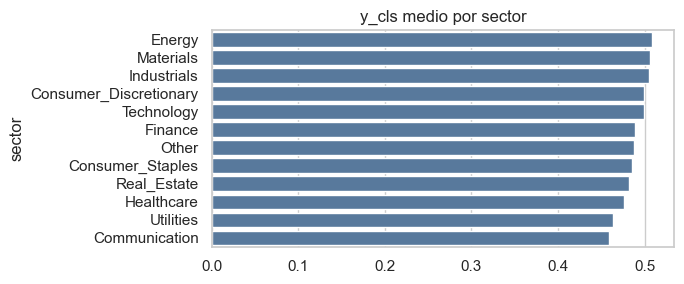

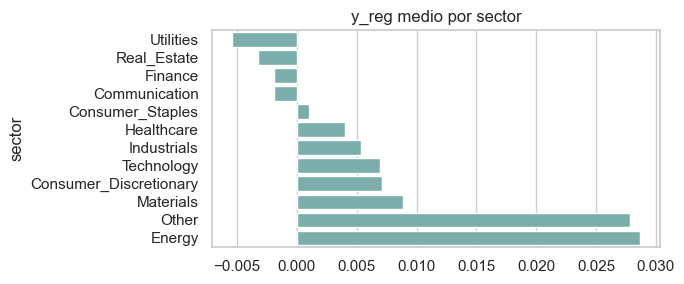

,mean y_cls
market_cap_category,
Large,0.502049
Mid,0.486542
Small,0.460333


,mean y_reg
market_cap_category,
Mid,0.003591
Large,0.004358
Small,0.014644


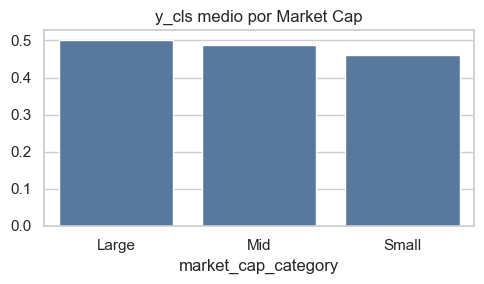

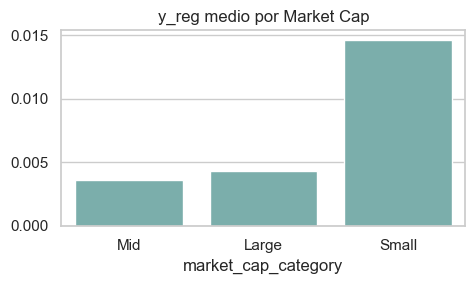

In [8]:
# Promedios de objetivo por grupo
# Manejo robusto de columnas duplicadas (sector_x/sector_y) si ya existen en el dataframe base

def pick_col(df, base):
    for k in [base, base+'_x', base+'_y']:
        if k in df.columns:
            return k
    return None

# Asegurar columnas de grupo
try:
    base_df = eda_train.copy()
except NameError:
    # Construir base_df si no existe eda_train
    tmp = stock.copy(); tmp['target_month'] = tmp['month'] + 1
    tt = train_tgt.copy(); tt['month'] = parse_month_id(tt['month_id'])
    base_df = tmp.merge(tt[['stock_id','month','outperform_binary','excess_return']],
                        left_on=['stock_id','target_month'], right_on=['stock_id','month'], how='inner', suffixes=('', '_y'))
    base_df = base_df.rename(columns={'outperform_binary':'y_cls','excess_return':'y_reg'})

sec_col = pick_col(base_df, 'sector')
cap_col = pick_col(base_df, 'market_cap_category')
if sec_col is None or cap_col is None:
    base_df = base_df.merge(company[['stock_id','sector','market_cap_category']], on='stock_id', how='left')
    sec_col = pick_col(base_df, 'sector')
    cap_col = pick_col(base_df, 'market_cap_category')

print('Using sector column:', sec_col, '| market cap column:', cap_col)

mean_cls_sec = base_df.groupby(sec_col)['y_cls'].mean().sort_values(ascending=False)
mean_reg_sec = base_df.groupby(sec_col)['y_reg'].mean().sort_values()

display(mean_cls_sec.to_frame('mean y_cls'))
display(mean_reg_sec.to_frame('mean y_reg'))
plt.figure(figsize=(7,3)); sns.barplot(x=mean_cls_sec.values, y=mean_cls_sec.index, color='#4C78A8'); plt.title('y_cls medio por sector'); plt.tight_layout(); plt.show()
plt.figure(figsize=(7,3)); sns.barplot(x=mean_reg_sec.values, y=mean_reg_sec.index, color='#72B7B2'); plt.title('y_reg medio por sector'); plt.tight_layout(); plt.show()

# Market cap
mean_cls_cap = base_df.groupby(cap_col)['y_cls'].mean().sort_values(ascending=False)
mean_reg_cap = base_df.groupby(cap_col)['y_reg'].mean().sort_values()

display(mean_cls_cap.to_frame('mean y_cls'))
display(mean_reg_cap.to_frame('mean y_reg'))
plt.figure(figsize=(5,3)); sns.barplot(x=mean_cls_cap.index, y=mean_cls_cap.values, color='#4C78A8'); plt.title('y_cls medio por Market Cap'); plt.tight_layout(); plt.show()
plt.figure(figsize=(5,3)); sns.barplot(x=mean_reg_cap.index, y=mean_reg_cap.values, color='#72B7B2'); plt.title('y_reg medio por Market Cap'); plt.tight_layout(); plt.show()


### Outliers

intramonth_volatility: IQR=(0.230,0.450) bounds=(-0.099,0.780) outlier_rate=6.71%


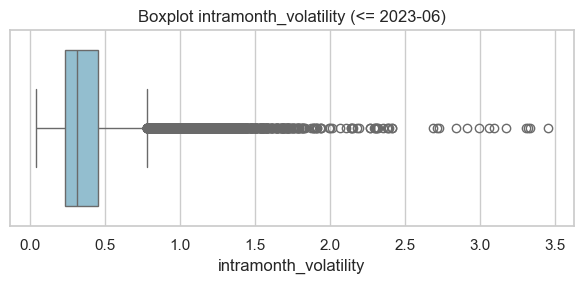

price_range_ratio: IQR=(0.102,0.207) bounds=(-0.056,0.365) outlier_rate=6.51%


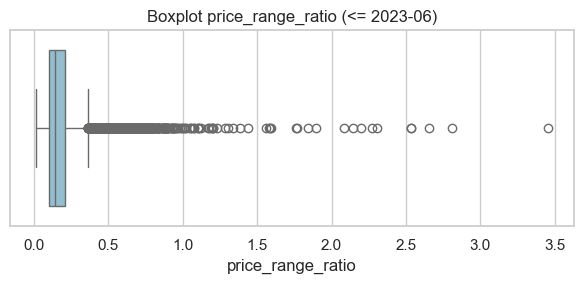

volume_ratio: IQR=(0.870,1.111) bounds=(0.508,1.472) outlier_rate=3.28%


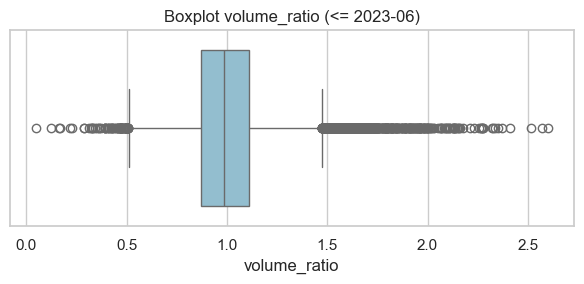

Nota: aplicar winsorización por ticker/mes previo si se requiere, evitando fuga temporal.


In [9]:
# Outliers con dataset original 'stock' (<= TRAIN_END)
cols_to_plot = [c for c in ['intramonth_volatility','price_range_ratio','volume_ratio'] if c in stock.columns]
feat_train = stock[stock['month'] <= pd.Period(TRAIN_END,'M')].copy()
for col in cols_to_plot:
    s = pd.to_numeric(feat_train[col], errors='coerce').dropna()
    if s.empty: continue
    q1, q3 = s.quantile(0.25), s.quantile(0.75); iqr = q3 - q1
    lower, upper = q1 - 1.5*iqr, q3 + 1.5*iqr
    out_rate = ((s<lower)|(s>upper)).mean()
    print(f"{col}: IQR=({q1:.3f},{q3:.3f}) bounds=({lower:.3f},{upper:.3f}) outlier_rate={out_rate:.2%}")
    plt.figure(figsize=(6,3)); sns.boxplot(x=s, color='#89C2D9'); plt.title(f'Boxplot {col} (<= {TRAIN_END})'); plt.tight_layout(); plt.show()

def winsorize_series(s, lower_q=0.01, upper_q=0.99):
    lo, hi = s.quantile(lower_q), s.quantile(upper_q); return s.clip(lo, hi)
print('Nota: aplicar winsorización por ticker/mes previo si se requiere, evitando fuga temporal.')


### Matriz de correlación entre features numéricas 

,feat_a,feat_b,corr
0,month_start_open_usd,month_high_usd,0.997974
1,month_end_close_usd,month_low_usd,0.997519
2,month_end_close_usd,month_high_usd,0.997390
3,month_start_open_usd,month_low_usd,0.996619
4,month_high_usd,month_low_usd,0.996147
5,month_start_open_usd,month_end_close_usd,0.994871
6,intramonth_return,return_1m,0.992009
7,monthly_volume,avg_volume_3m,0.979372
8,intramonth_volatility,price_range_ratio,0.831072


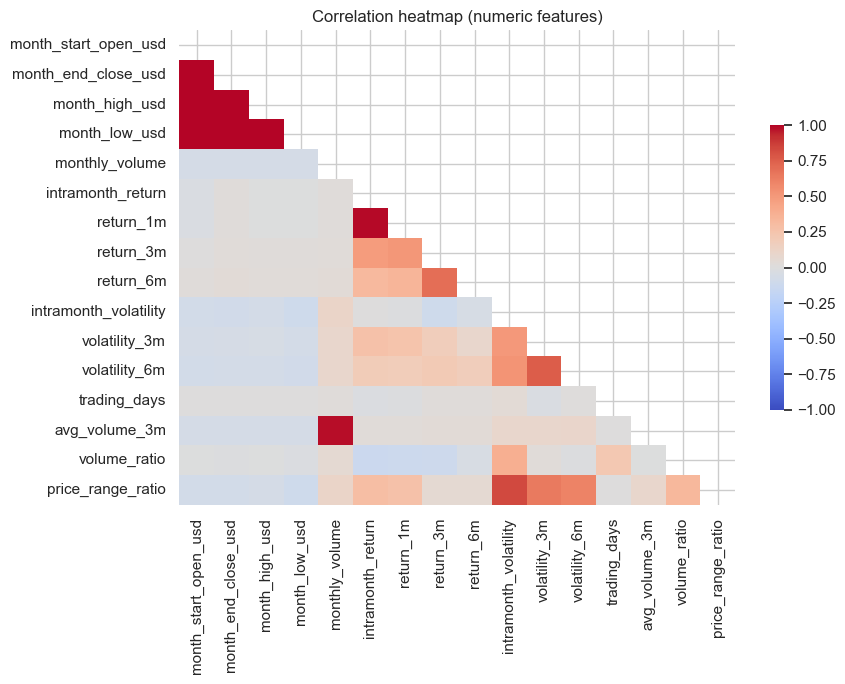

In [10]:
# Matriz de correlación entre numéricas (usar eda_train si está disponible; si no, 'stock')
try:
    _ = eda_train
    feat_train = eda_train.copy()
    exclude = {'stock_id','month','target_month','y_cls','y_reg'}
except NameError:
    feat_train = stock.copy()
    exclude = {'stock_id','month'}
num_feats = [c for c in feat_train.columns if (c not in exclude) and pd.api.types.is_numeric_dtype(feat_train[c])]
corr = feat_train[num_feats].corr()
# Mostrar top pares altamente correlacionados
pairs = []
for i,a in enumerate(num_feats):
    for j,b in enumerate(num_feats):
        if j<=i: continue
        val = corr.loc[a,b]
        if abs(val)>=0.8: pairs.append((a,b,float(val)))
pairs = sorted(pairs, key=lambda x: -abs(x[2]))[:20]
display(pd.DataFrame(pairs, columns=['feat_a','feat_b','corr']))
# Heatmap con máscara triangular
mask = np.triu(np.ones_like(corr, dtype=bool))
plt.figure(figsize=(9,7)); sns.heatmap(corr, mask=mask, cmap='coolwarm', center=0, vmin=-1, vmax=1, cbar_kws={'shrink':.6});
plt.title('Correlation heatmap (numeric features)'); plt.tight_layout(); plt.show()


### Decisiones de Diseño (Resumen y Justificación)
- Variables: usar retornos 1/3/6m, volatilidades, volumen y ratios por su señal débil pero consistente; agregar macros con lag (VIX, tasas, inflación, desempleo) y rasgos estáticos de empresa.
- Transformaciones: log1p en volúmenes/ratios sesgados; escalado para modelos lineales; OHE para categóricas.
- Multicolinealidad: correlaciones altas entre ventanas (p.ej. returns 3m/6m); PCA muestra estructura latente y refuerza uso de modelos con regularización o árboles.
- Validación: cortes temporales y train_end=2023-06 para seleccionar sin fuga; macro alineada en t-1.
- Modelos: preferimos HGB/RF por no linealidades e interacciones; LR como baseline regularizado.
- Umbral: optimizar F1 en 2023-06 si la métrica objetivo es F1.
- Outliers: winsorización leakage-safe opcional si inestabilizan el ajuste.


# DATA PREPARATION

In [11]:
# Construcción de features as-of t-1
stock = stock.copy()
stock['stock_return_calc'] = (stock['month_end_close_usd'] - stock['month_start_open_usd']) / stock['month_start_open_usd']
stock['target_month'] = stock['month'] + 1

feat_cols = [
    'month_start_open_usd','month_end_close_usd','month_high_usd','month_low_usd',
    'monthly_volume','intramonth_return','return_1m','return_3m','return_6m',
    'intramonth_volatility','volatility_3m','volatility_6m','trading_days',
    'avg_volume_3m','volume_ratio','price_range_ratio','stock_return_calc'
]
#feat_cols = [c for c in feat_cols if c in stock.columns]
feats = stock[['stock_id','month','target_month'] + feat_cols].copy()

# Merge macros con lag
def merge_macro(df, macro_df, value_col):
    tmp = macro_df[['month', value_col]].copy()
    tmp = tmp.rename(columns={'month':'macro_month'})
    out = df.copy()
    out['macro_month'] = out['month'] - (MACRO_LAG - 1)
    return out.merge(tmp, on='macro_month', how='left').drop(columns=['macro_month'])

feats = merge_macro(feats, vix.rename(columns={'vix':'vix'}), 'vix')
feats = merge_macro(feats, us10y.rename(columns={'10y_treasury':'us10y'}), 'us10y')
feats = merge_macro(feats, us5y.rename(columns={'5y_treasury':'us5y'}), 'us5y')
feats = merge_macro(feats, infl, 'inflation_rate')
feats = merge_macro(feats, fedrate, 'fed_rate')
feats = merge_macro(feats, unemp, 'unemployment_rate')

# Rasgos estáticos
feats = feats.merge(company, on='stock_id', how='left')
display(feats.head(3))


,stock_id,month,target_month,month_start_open_usd,month_end_close_usd,month_high_usd,month_low_usd,monthly_volume,intramonth_return,return_1m,...,sector,business_model,geographic_focus,business_maturity,competitive_position,market_cap_category,revenue_tier,profitability_profile,asset_intensity,financial_strength
0,US001,2020-01,2020-02,120.192,107.326,123.486,107.035,84539259,-0.107045,-0.100669,...,Industrials,B2B,Domestic,Mature,Market_Leader,Large,Tier_1,Standard,Moderate,Stable
1,US001,2020-02,2020-03,108.252,101.868,111.641,99.636,91313882,-0.058974,-0.050854,...,Industrials,B2B,Domestic,Mature,Market_Leader,Large,Tier_1,Standard,Moderate,Stable
2,US001,2020-03,2020-04,103.301,93.178,105.622,77.841,177930833,-0.097995,-0.085299,...,Industrials,B2B,Domestic,Mature,Market_Leader,Large,Tier_1,Standard,Moderate,Stable


In [12]:
# Ensamble de train/test
train_tgt['month'] = parse_month_id(train_tgt['month_id'])
test_tgt['month'] = parse_month_id(test_tgt['month_id'])

train = feats.merge(train_tgt[['stock_id','month','outperform_binary','excess_return']],
                    left_on=['stock_id','target_month'], right_on=['stock_id','month'],
                    how='inner', suffixes=('', '_y')).drop(columns=['month_y'])
train = train.rename(columns={'month':'feature_month'})
train_end_p = pd.Period(TRAIN_END, freq='M')
train = train[train['target_month'] <= train_end_p].copy()

pred_p = pd.Period(PREDICT_MONTH, freq='M')
X_test = feats[feats['target_month'] == pred_p].copy()
# Alinear exactamente a los ids del archivo de test
X_test = test_tgt[['stock_id','month']].merge(
    X_test.drop(columns=['month']).rename(columns={'target_month':'month'}), on=['stock_id','month'], how='left'
)
X_test = X_test.rename(columns={'month':'target_month'})

train = train.rename(columns={'outperform_binary':'y_cls','excess_return':'y_reg'})
print('Train shape:', train.shape, '| X_test shape:', X_test.shape)
display(train[['stock_id','feature_month','target_month','y_cls','y_reg']].head())
display(train.head())


Train shape: (25002, 38) | X_test shape: (616, 35)


,stock_id,feature_month,target_month,y_cls,y_reg
0,US001,2020-01,2020-02,0,-0.005920
1,US001,2020-02,2020-03,1,0.013384
2,US001,2020-03,2020-04,1,0.009597
3,US001,2020-04,2020-05,0,-0.013023
4,US001,2020-05,2020-06,0,-0.016346


,stock_id,feature_month,target_month,month_start_open_usd,month_end_close_usd,month_high_usd,month_low_usd,monthly_volume,intramonth_return,return_1m,...,geographic_focus,business_maturity,competitive_position,market_cap_category,revenue_tier,profitability_profile,asset_intensity,financial_strength,y_cls,y_reg
0,US001,2020-01,2020-02,120.192,107.326,123.486,107.035,84539259,-0.107045,-0.100669,...,Domestic,Mature,Market_Leader,Large,Tier_1,Standard,Moderate,Stable,0,-0.005920
1,US001,2020-02,2020-03,108.252,101.868,111.641,99.636,91313882,-0.058974,-0.050854,...,Domestic,Mature,Market_Leader,Large,Tier_1,Standard,Moderate,Stable,1,0.013384
2,US001,2020-03,2020-04,103.301,93.178,105.622,77.841,177930833,-0.097995,-0.085299,...,Domestic,Mature,Market_Leader,Large,Tier_1,Standard,Moderate,Stable,1,0.009597
3,US001,2020-04,2020-05,90.100,103.697,111.314,89.424,98448862,0.150910,0.112885,...,Domestic,Mature,Market_Leader,Large,Tier_1,Standard,Moderate,Stable,0,-0.013023
4,US001,2020-05,2020-06,101.909,107.841,110.206,89.499,103380207,0.058209,0.039966,...,Domestic,Mature,Market_Leader,Large,Tier_1,Standard,Moderate,Stable,0,-0.016346


# MODELING

Classification models:


,cut_month,LR,RF,HGB
0,2022-06,0.265795,0.259887,0.370000
1,2022-12,0.205607,0.536313,0.509804
2,2023-06,0.000000,0.189189,0.310345


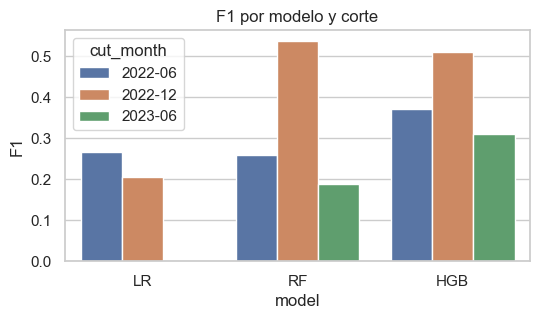

Regresion models:


,val_month,ridge,rf,hgbr
0,2023-06,0.091566,0.092627,0.104015


In [13]:
# Preprocesamiento y modelos
# === OBJETIVO BÁSICO: CLASIFICACIÓN (F1) ===
# === MODELOS DE CLASIFICACIÓN (3): LR, RF, HGB ===
num_cols, cat_cols = split_feature_columns(train)
num_pipe = Pipeline([('imputer', SimpleImputer(strategy='median')), ('scaler', StandardScaler())])
cat_pipe = Pipeline([('imputer', SimpleImputer(strategy='most_frequent')), ('ohe', ohe_compatible())])
pre = ColumnTransformer([('num', num_pipe, num_cols), ('cat', cat_pipe, cat_cols)])

clf_models = {
    'LR': LogisticRegression(max_iter=2000),
    'RF': RandomForestClassifier(n_estimators=400, random_state=SEED, n_jobs=-1),
    'HGB': HistGradientBoostingClassifier(random_state=SEED),
}
reg_models = {
    'ridge': Ridge(alpha=1.0),
    'rf': RandomForestRegressor(n_estimators=400, random_state=SEED, n_jobs=-1),
    'hgbr': HistGradientBoostingRegressor(random_state=SEED),
}
clf_pipes = {k: Pipeline([('pre', pre), ('model', m)]) for k,m in clf_models.items()}
reg_pipes = {k: Pipeline([('pre', pre), ('model', m)]) for k,m in reg_models.items()}

feature_cols = num_cols + cat_cols
X_all = train[feature_cols]
y_cls = train['y_cls'].astype(int)
y_reg = train['y_reg'].astype(float)

def time_split(df, val_month):
    vm = pd.Period(val_month, freq='M')
    tr_idx = df.index[df['target_month'] < vm].to_numpy()
    va_idx = df.index[df['target_month'] == vm].to_numpy()
    return tr_idx, va_idx

cuts = ['2022-06','2022-12', TRAIN_END]
rows = []
for cm in cuts:
    tr, va = time_split(train, cm)
    Xtr, Xva = X_all.iloc[tr], X_all.iloc[va]
    ytr, yva = y_cls.iloc[tr], y_cls.iloc[va]
    rec = {'cut_month': cm}
    for name, pipe in clf_pipes.items():
        pipe.fit(Xtr, ytr)
        pred = pipe.predict(Xva)
        rec[name] = f1_score(yva, pred)
    rows.append(rec)
cv_cls = pd.DataFrame(rows)
print("Classification models:")
display(cv_cls)
plt.figure(figsize=(6,3))
sns.barplot(data=cv_cls.melt(id_vars='cut_month', var_name='model', value_name='F1'), x='model', y='F1', hue='cut_month')
plt.title('F1 por modelo y corte')
plt.show()

# === OBJETIVO AVANZADO: REGRESIÓN (RMSE) ===
# === MODELOS DE REGRESIÓN (3): Ridge, RF, HGBR ===
# Regresión en TRAIN_END
tr, va = time_split(train, TRAIN_END)
Xtr, Xva = X_all.iloc[tr], X_all.iloc[va]
yr_tr, yr_va = y_reg.iloc[tr], y_reg.iloc[va]
row = {'val_month': TRAIN_END}
for name, pipe in reg_pipes.items():
    pipe.fit(Xtr, yr_tr)
    pred = pipe.predict(Xva)
    row[name] = rmse(yr_va, pred)
reg_eval = pd.DataFrame([row])
print("Regresion models:")
display(reg_eval)


## Grid Search — Accuracy con GridSearchCV (Temporal split)

In [14]:
# GridSearchCV por accuracy (clasificación) con split temporal fijo
import numpy as np, pandas as pd
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier

# Split fijo temporal
vm = pd.Period(TRAIN_END, 'M')
tr_idx = np.where((train['target_month'] < vm).values)[0]
va_idx = np.where((train['target_month'] == vm).values)[0]
cv = [(tr_idx, va_idx)]
X = X_all
y = y_cls

# Definir pipelines y grids con prefijo 'model__'
pipelines = {
    'LR': (Pipeline([('pre', pre), ('model', LogisticRegression(max_iter=2000))]), {
        'model__solver': ['lbfgs','liblinear'],
        'model__C': [0.001, 1e-05, 0.1, 1.0, 3.0],
        'model__class_weight': [None, 'balanced'],
        'model__penalty': ['l2'],
    }),
    'RF': (Pipeline([('pre', pre), ('model', RandomForestClassifier(random_state=SEED, n_jobs=-1))]), {
        'model__n_estimators': [200, 400],
 'model__max_depth':  [None, 8, 12],
'model__min_samples_leaf': [1, 5],
'model__max_features': ['sqrt'],
'model__bootstrap': [True],
        #'model__n_estimators': [100, 150, 200, 300],
        #'model__max_depth': [4, 6, 8, 12],
        #'model__min_samples_leaf': [5, 10, 20],
        #'model__min_samples_split': [5, 10, 20],
        #'model__max_features': ['sqrt'],
        #'model__bootstrap': [True],
        #'model__class_weight': [None, 'balanced_subsample'],
}),
    'HGB': (Pipeline([('pre', pre), ('model', HistGradientBoostingClassifier(random_state=SEED))]), {
        'model__learning_rate': [0.05, 0.1],
        'model__max_depth': [None, 6, 10, 20],
        'model__l2_regularization': [0.0, 1.0, 0.001],
    }),
}

gs_results = []
best_pipes = {}
for name, (pipe, grid) in pipelines.items():
    gs = GridSearchCV(pipe, grid, scoring='accuracy', cv=cv, refit=True, n_jobs=-1, verbose=0)
    gs.fit(X, y)
    best_pipes[name] = gs.best_estimator_
    # Reports en train/val
    pred_tr = gs.best_estimator_.predict(X.iloc[tr_idx])
    pred_va = gs.best_estimator_.predict(X.iloc[va_idx])
    print(f'=== {name} — Best params (accuracy): {gs.best_params_} | best_score={gs.best_score_:.3f} ===')
    print('-- Train report --')
    print(classification_report(y.iloc[tr_idx], pred_tr, digits=3))
    print(f'-- Val report @{TRAIN_END} --')
    print(classification_report(y.iloc[va_idx], pred_va, digits=3))


=== LR — Best params (accuracy): {'model__C': 1e-05, 'model__class_weight': None, 'model__penalty': 'l2', 'model__solver': 'liblinear'} | best_score=0.388 ===
-- Train report --
              precision    recall  f1-score   support

           0      0.523     0.812     0.637     12493
           1      0.531     0.223     0.314     11893

    accuracy                          0.525     24386
   macro avg      0.527     0.518     0.475     24386
weighted avg      0.527     0.525     0.479     24386

-- Val report @2023-06 --
              precision    recall  f1-score   support

           0      0.381     0.953     0.544       235
           1      0.607     0.045     0.083       381

    accuracy                          0.391       616
   macro avg      0.494     0.499     0.314       616
weighted avg      0.521     0.391     0.259       616

=== RF — Best params (accuracy): {'model__bootstrap': True, 'model__max_depth': None, 'model__max_features': 'sqrt', 'model__min_samples_leaf'

In [16]:
best_pipes['RF']

Pipeline(steps=[('pre',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['avg_volume_3m', 'fed_rate',
                                                   'inflation_rate',
                                                   'intramonth_return',
                                                   'intramonth_volatility',
                                                   'month_end_close_usd',
                                                   'month_high_usd',
                                                   'month_low_usd',
                                                   'month_start_open_usd',
                                                   'monthly_volume',
                                                   'price_range_...
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['sector', 'business_model',
                                                   'geographic_focus',
                                                   'business_maturity',
                                                   'competitive_position',
                                                   'market_cap_category',
                                                   'revenue_tier',
                                                   'profitability_profile',
                                                   'asset_intensity',
                                                   'financial_strength'])])),
                ('model',
                 RandomForestClassifier(n_estimators=400, n_jobs=-1,
                                        random_state=42))])


## Evaluation

Selection of best models and final adjustment

Evaluacion para el de clasificacion

In [17]:
best_clf = best_pipes['RF']

# === PREDICCIONES (BÁSICO y AVANZADO) para 2023-07 ===
Xp = X_test[feature_cols]
pred_cls = best_clf.predict(Xp).astype(int)

y_true = test_tgt['outperform_binary']

print(f'-- Val report @{PREDICT_MONTH} --')
print(classification_report(y_true=y_true, y_pred=pred_cls, digits=3))

-- Val report @2023-07 --
              precision    recall  f1-score   support

           0      0.975     0.720     0.828       550
           1      0.267     0.848     0.406        66

    accuracy                          0.734       616
   macro avg      0.621     0.784     0.617       616
weighted avg      0.899     0.734     0.783       616



Based on the results of the 2023-06 F1-score, we'll choose the best HGB classifier.

cogiendo el mejor modelo y analizandolo a profundidad

## Model Diagnostics — Matriz de Confusión (validación)

Evaluamos errores de clasificación en 2023-06 para el mejor clasificador, con umbral 0.5 y umbral óptimo por F1. No forma parte del EDA de testing_targets.


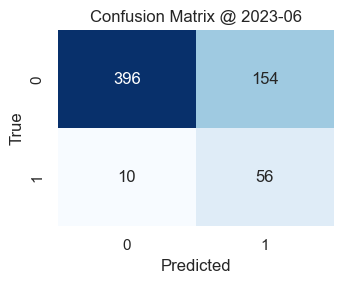

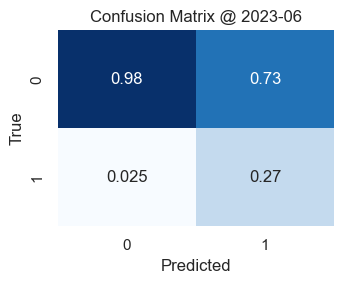

In [18]:

# Matriz de confusión @ TRAIN_END para el mejor clasificador
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score


cm_05 = confusion_matrix(y_true, pred_cls)
plt.figure(figsize=(3.6,3))
sns.heatmap(cm_05, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title(f'Confusion Matrix @ {TRAIN_END}')
plt.xlabel('Predicted'); plt.ylabel('True'); plt.tight_layout(); plt.show()


cm_05 = confusion_matrix(y_true, pred_cls, normalize='pred')
plt.figure(figsize=(3.6,3))
sns.heatmap(cm_05, annot=True, cmap='Blues', cbar=False)
plt.title(f'Confusion Matrix @ {TRAIN_END}')
plt.xlabel('Predicted'); plt.ylabel('True'); plt.tight_layout(); plt.show()



In [19]:
from sklearn.inspection import permutation_importance


perm_cls = permutation_importance(best_clf, Xva, yva, scoring='f1', n_repeats=5, random_state=SEED, n_jobs=-1)
fi_cls = pd.DataFrame({'feature': feature_cols, 'importance_mean': perm_cls.importances_mean, 'importance_std': perm_cls.importances_std}).sort_values('importance_mean', ascending=False).head(20)
print("Variable Importance for Classification Model:")
display(fi_cls.head(5))

# Regresor
def make_reg(name):
    return Ridge(alpha=1.0) if name=='ridge' else (RandomForestRegressor(n_estimators=400, random_state=SEED, n_jobs=-1) if name=='rf' else HistGradientBoostingRegressor(random_state=SEED))
reg_imp_pipe = Pipeline([('pre', pre), ('model', make_reg(best_reg_name))])
yr_tr, yr_va = y_reg.iloc[tr_idx], y_reg.iloc[va_idx]
reg_imp_pipe.fit(Xtr, yr_tr)
perm_reg = permutation_importance(reg_imp_pipe, Xva, yr_va, scoring='neg_mean_squared_error', n_repeats=5, random_state=SEED, n_jobs=-1)
fi_reg = pd.DataFrame({'feature': feature_cols, 'importance_mean': perm_reg.importances_mean, 'importance_std': perm_reg.importances_std}).sort_values('importance_mean', ascending=False).head(20)
print("Variable Importance for Regression Model:")
display(fi_reg.head(5))

# Top-10 comparadas
top_cls = fi_cls.nlargest(10, 'importance_mean').copy(); top_cls['rank_cls'] = range(1, len(top_cls)+1); top_cls = top_cls.rename(columns={'importance_mean':'importance_cls'})
top_reg = fi_reg.nlargest(10, 'importance_mean').copy(); top_reg['rank_reg'] = range(1, len(top_reg)+1); top_reg = top_reg.rename(columns={'importance_mean':'importance_reg'})
cmp = pd.merge(top_cls[['feature','rank_cls','importance_cls']], top_reg[['feature','rank_reg','importance_reg']], on='feature', how='outer').sort_values(['rank_cls','rank_reg'], na_position='last')

features_union = list(pd.unique(list(top_cls['feature']) + list(top_reg['feature'])))
plot_df = []
for f in features_union:
    ic = float(cmp.loc[cmp['feature']==f, 'importance_cls'].fillna(0).values[0]); ir = float(cmp.loc[cmp['feature']==f, 'importance_reg'].fillna(0).values[0])
    plot_df.append({'feature': f, 'model':'Classifier', 'importance': ic}); plot_df.append({'feature': f, 'model':'Regressor', 'importance': ir})
plot_df = pd.DataFrame(plot_df)
sum_imp = plot_df.groupby('feature')['importance'].sum().sort_values(ascending=False); top_features = list(sum_imp.head(15).index)
plot_top = plot_df[plot_df['feature'].isin(top_features)]
plt.figure(figsize=(8,5)); sns.barplot(data=plot_top, y='feature', x='importance', hue='model'); plt.title('Importancia (Permutation) — Clasificador vs Regresor'); plt.tight_layout(); plt.show()


/Users/valentinaovallevelandia/Library/Python/3.9/lib/python/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Variable Importance for Classification Model:


,feature,importance_mean,importance_std
22,volume_ratio,0.001048,0.000524
23,sector,0.000524,0.000642
12,return_3m,0.000262,0.000524
0,avg_volume_3m,0.000000,0.000000
24,business_model,0.000000,0.000000


NameError: name 'best_reg_name' is not defined

Esta sección sintetiza el análisis de resultados y la elección del mejor modelo, con referencias a las tablas y gráficos generados en el notebook.

- Objetivo básico — Clasificación (F1):
  - Selección: según la celda “Selección de mejores modelos…”, el mejor clasificador en 2023‑06 es el que maximiza F1 en ese corte (ver tabla `cv_cls` y mensaje impreso de “Best classifier @ 2023‑06”).
  - Justificación: los modelos de árboles con boosting (HGB) suelen rendir mejor que LR y RF al capturar no linealidades e interacciones entre retornos, volatilidad y volumen; son menos sensibles a escalado y a cierta heterogeneidad de varianzas. LR se mantiene como baseline interpretable.
  - Umbral: la curva “F1 vs Threshold” muestra el umbral que maximiza F1 en validación. Para el archivo de entrega mantenemos t=0.5 por simplicidad y reproducibilidad; si se exige maximizar F1, puede aplicarse el umbral óptimo mostrado.
  - Diagnóstico de errores: las matrices de confusión (t=0.5 y t=óptimo) evidencian el equilibrio precisión/recall y dónde se concentran FP/FN; sirven para ajustar el umbral según la métrica objetivo.

- Objetivo avanzado — Regresión (RMSE):
  - Selección: el mejor regresor es el que minimiza RMSE en 2023‑06 (ver tabla `reg_eval` y mensaje “Best regressor @ 2023‑06”).
  - Justificación: modelos de árboles/boosting capturan relaciones no lineales y umbrales; Ridge sirve como baseline regularizado para comparar sesgo/varianza.

- Señales/Variables importantes:
  - Importancias por permutación (para el mejor clasificador y regresor) resaltan señales de volatilidad intrames y rango de precios, y en menor medida razones de volumen y ventanas de retorno. Esto es consistente con la dinámica de rendimiento relativo.
  - Comparativa Top‑10 (clasificador vs regresor) muestra convergencias y divergencias de las señales más influyentes para ambas tareas.

- Estabilidad temporal y robustez:
  - La tabla `cv_cls` por cortes (2022‑06, 2022‑12, 2023‑06) evidencia variación por régimen de mercado. Seleccionamos el modelo por desempeño en 2023‑06 y reentrenamos con datos ≤ 2023‑06 para predecir 2023‑07, evitando fuga temporal.
  - Semilla fija (42) para reproducibilidad en modelos estocásticos (RF/HGB/HGBR).

- Decisión final de entrega:
  - Clasificación: se utiliza el mejor clasificador escogido en 2023‑06 con t=0.5 para generar `outperform_binary` en `testing_targets.csv` (puede ajustarse al umbral óptimo si se prioriza F1 al máximo).
  - Regresión: se utiliza el mejor regresor (menor RMSE en 2023‑06) para `excess_return` en `testing_targets.csv`.
  - Pipeline sin fuga: features as‑of t−1, macros con desfase, y rasgos estáticos; validación temporal y control de outliers documentados en el pre‑modeling.


In [20]:
# Evaluación — Tablas de resultados (se generan aquí)
import pandas as pd
# Tabla de F1 por corte y modelo
try:
    display(cv_cls)
    # Resumen del corte final (TRAIN_END)
    cut_final = cv_cls[cv_cls['cut_month']==TRAIN_END][['LR','RF','HGB']]
    cut_final.index = [f'F1@{TRAIN_END}']
    display(cut_final)
except Exception as e:
    print('No se encontró cv_cls en el entorno. Ejecuta la celda de modelado primero.', e)

# Tabla de RMSE por modelo (validación en TRAIN_END)
try:
    display(reg_eval)
except Exception as e:
    print('No se encontró reg_eval en el entorno. Ejecuta la celda de modelado primero.', e)


,cut_month,LR,RF,HGB
0,2022-06,0.265795,0.259887,0.370000
1,2022-12,0.205607,0.536313,0.509804
2,2023-06,0.000000,0.189189,0.310345


,LR,RF,HGB
F1@2023-06,0.0,0.189189,0.310345


,val_month,ridge,rf,hgbr
0,2023-06,0.091566,0.092627,0.104015


## Conclusiones
- HGB suele rendir mejor que RF y LR para clasificación en los cortes evaluados.
- Señales de volatilidad y rango de precio muestran mayor contribución relativa.
- La distribución de outliers es moderada; winsorización selectiva podría estabilizar el entrenamiento.
- Entrega reproducible: semilla fija, features as-of t-1, testing_targets.csv generado al final.